# Analysis of Resulting PoLo Paths

Here, I analyze the paths found by the PoLo method and check how closely they match the MOAs in [DrugMechDB](https://sulab.github.io/DrugMechDB/).

In [37]:
import pandas as pd
import os.path as osp
import os
import statistics
from collections import Counter
from urllib import request
import json
from matplotlib import pyplot as plt
from matplotlib_venn import venn2_unweighted
import numpy as np
from tqdm import tqdm
from collections import defaultdict

## Load in the DrugMechDB file:

In [38]:
VALIDATION_DIR = '../data/validation'
MAPPING_DIR = '../data/mappings'
KG_DIR = '../data/kg'

In [39]:
url = "https://raw.githubusercontent.com/SuLab/DrugMechDB/1.0/indication_paths.json"

In [40]:
with request.urlopen(url) as fl:
    data_json = json.loads(fl.read())
    #json.dump(dict(data_json), filepath)
    #print(data_json)

Are there the same number of paths as before?

In [41]:
len(data_json)

123

In [42]:
data_json

[{'directed': True,
  'multigraph': True,
  'graph': {'drug': 'imatinib',
   'disease': 'CML (ph+)',
   'drugbank': 'DB00619',
   'drug_mesh': 'MESH:D000068877',
   'disease_mesh': 'MESH:D015464'},
  'nodes': [{'id': 'MESH:D000068877', 'name': 'imatinib', 'label': 'Drug'},
   {'id': 'UniProt:P00519', 'name': 'BCR/ABL', 'label': 'Protein'},
   {'id': 'MESH:D015464', 'name': 'CML (ph+)', 'label': 'Disease'}],
  'links': [{'source': 'MESH:D000068877',
    'target': 'UniProt:P00519',
    'key': 'INHIBITS'},
   {'source': 'UniProt:P00519', 'target': 'MESH:D015464', 'key': 'CAUSES'}]},
 {'directed': True,
  'multigraph': True,
  'graph': {'drug': 'imatinib',
   'disease': 'Systemic mast cell disease',
   'drugbank': 'DB00619',
   'drug_mesh': 'MESH:D000068877',
   'disease_mesh': 'MESH:D034721'},
  'nodes': [{'id': 'MESH:D000068877', 'name': 'imatinib', 'label': 'Drug'},
   {'id': 'UniProt:P10721', 'name': 'c-Kit', 'label': 'Protein'},
   {'id': 'GO:0008283',
    'name': 'Cellular proliferat

Create a new object containing only those which end in a BP node.

Let's also get all the unique BPs involved:

**It is worth noting that there are lots of non-drug compounds in here, such as carbovir triphosphate and prostaglandins, which act as middle players in the paths.**

In [43]:
bp_paths = []
bp_path_lengths = []
bps = set()
for path in data_json:
    for count, node in enumerate(path['nodes']):
    # if any node is BP,
        if node['label'] == 'Biological Process':
            bp_paths.append(path)
            bp_path_lengths.append(count)
            bps.add(path['nodes'][count]['id'])

In [44]:
len(bp_paths)

100

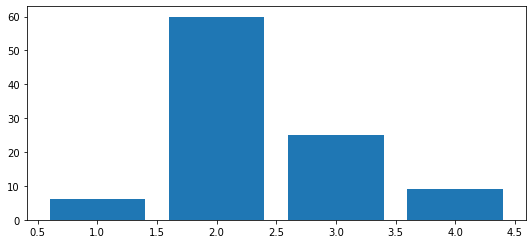

In [45]:
bpath_lens = Counter(bp_path_lengths)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.bar(bpath_lens.keys(), bpath_lens.values())

plt.show()

## Extracting MOAs for Result Validation

Here, we get these MOAs synchronized with the IDs used in our KG, and then we save them in a file for easy comparison against test results.

First, in the `preprocess_drugmechdb` notebook, we've seen that some of the identifiers need to map to others. We'll use the files which were prepared there to do easy mapping here.

In [46]:
# read a json as a dict
with open(osp.join(MAPPING_DIR, 'uniprot2ncbi.json')) as fl:
    uniprot2ncbi = json.load(fl)

with open(osp.join(MAPPING_DIR, 'drug_id_mapping.json')) as fl:
    drug_id_mapping = json.load(fl)

In [47]:
len(drug_id_mapping)

63

Using these dictionaries, we'll map the nodes to the ontologies used in the KG:

In [48]:
def map_node(node):
    if node['label'] == 'Drug' and node['name'] in drug_id_mapping:
        return drug_id_mapping[node['name']]
    elif node['label'] == 'Protein' and node['id'] in uniprot2ncbi:
        return uniprot2ncbi[node['id']]
    else:
        return node['id']

Now, get a dictionary of the nodes and relations in each MOA:

In [49]:
validation_moas = defaultdict(lambda: {'nodes': None, 'relations': None})
not_mapped = set()
for path in data_json:
    # map the drug name to its pubchem ID
    if path['nodes'][0]['name'] not in drug_id_mapping:
        not_mapped.add(path['nodes'][0]['name'])
        continue
    start_node = drug_id_mapping[path['nodes'][0]['name']]
    for count, node in enumerate(path['nodes']):
        # if any node is BP,
        if node['label'] == 'Biological Process':
            end_node = path['nodes'][count]['id']
            # record those MOAs
            validation_moas[(start_node, end_node)]['nodes'] = [map_node(i) for i in path['nodes'][0:len(path['nodes'])-1]]
            validation_moas[(start_node, end_node)]['relations'] = [i['key'] for i in path['links'][0:len(path['links'])-1]]

len(validation_moas)

53

Does it look how we want it to?

- The keys are tuples comprising a pair of (drug, GO BP)
- The values are dictionaries containing:
    - nodes: a sequence of nodes in the MOA
    - relations: a sequence of relation types in the MOA, which might not necessarily correspond to those in the KG:

In [50]:
dict(validation_moas)

{('pubchem.compound:5291',
  'GO:0008283'): {'nodes': ['pubchem.compound:5291',
   'ncbigene:5156',
   'GO:0008283'], 'relations': ['INHIBITS', 'UP_REGULATES']},
 ('pubchem.compound:1983',
  'GO:0001659'): {'nodes': ['pubchem.compound:1983',
   'REACT:R-HSA-2162123',
   'UBERON:0000955',
   'GO:0001659'], 'relations': ['INHIBITS', 'LOCALIZED_TO', 'REGULATES']},
 ('pubchem.compound:2244',
  'GO:0007596'): {'nodes': ['pubchem.compound:2244',
   'ncbigene:5742',
   'GO:0007596'], 'relations': ['INHIBITS', 'INVOLVED_IN']},
 ('pubchem.compound:156391',
  'GO:0006954'): {'nodes': ['pubchem.compound:156391',
   'ncbigene:5743',
   'MESH:D011453',
   'GO:0006954'], 'relations': ['INHIBITS', 'PRODUCES', 'PART_OF']},
 ('pubchem.compound:5745',
  'GO:0006954'): {'nodes': ['pubchem.compound:5745',
   'ncbigene:2908',
   'ncbigene:5742',
   'MESH:D011453',
   'GO:0006954'], 'relations': ['ACTIVATES',
   'DOWN_REGULATES',
   'PRODUCES',
   'PART_OF']},
 ('pubchem.compound:5743',
  'GO:0006954'): {'n

## PoLo: Output Paths

Now, we'll get lists from the output file of PoLo:

In [51]:
OUTPUT_DIR = '../data/output'

First, write some functions to do all the desired analyses:

In [52]:
def get_paths(file_path, correct_only=True):
    """Extracts the paths from PoLo's output paths file.
    :param file_path: the path of the output file
    :param correct_only: boolean flag to determine whether or not to extract paths from correct matches only.

    returns a dict of the test pairs as keys and lists of the path patterns traversed as keys
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    breakpoints = [i for i, line in enumerate(lines) if line.startswith("#####################")]

    chunks = []
    startpoint = 0
    for brk in breakpoints:
        chunk = lines[startpoint:brk]
        if not correct_only:
            chunks.append(chunk)
        elif correct_only and chunk[1].strip() == 'Reward:1':
            chunks.append(chunk)
        startpoint = brk + 1

    pred_paths = dict()

    for chunk in chunks:
        srt = 0
        current_pair = tuple(chunk[0].split())
        pred_paths[current_pair] = {'nodes': [], 'relations': []}
        chunk = chunk[2::]
        breakpoints = [i for i, line in enumerate(chunk) if line.startswith("___")]
        for brk in breakpoints:
            entry = chunk[srt:brk]
            if entry[2].strip() == '1':
                pred_paths[current_pair]['nodes'].append(entry[0].strip().split('\t'))
                pred_paths[current_pair]['relations'].append(entry[1].strip().split('\t'))
            srt = brk + 1

    return pred_paths

In [53]:
def get_pattern_breakdown(pred_paths, key=None):
    """Gets a counter of all the path patterns found.
    
    If key is passed, returns the counter only for that particular test pair.
    """
    if key:
        patterns_traversed = pred_paths[key]['relations']

    else:
        patterns_traversed = []
        for val in pred_paths.values():
            patterns_traversed.extend(val['relations'])

    patterns_traversed = [[rel for rel in i if rel != 'NO_OP'] for i in patterns_traversed]
    patterns_traversed = [['GiG' if rel == '_GiG' else rel for rel in i ] for i in patterns_traversed]
    patterns_traversed = [str(i) for i in patterns_traversed]
    return Counter(patterns_traversed)

In [54]:
def plot_pattern_breakdown(pattern_counter, output_path):
    """Makes a histogram of the pattern counts (code written by ChatGPT)"""
    # Separate keys and values
    keys, values = zip(*pattern_counter.items())

    # Create a histogram
    plt.bar(keys, values)

    # Add labels and a title
    plt.xlabel('Metapaths')
    plt.ylabel('Correct Predictions')
    plt.title('Metapath Instances Used to Predict True Pairs')

    # Rotate x-axis labels by 90 degrees
    plt.xticks(rotation=90)


    # Save the plot to a file (e.g., 'histogram.png')
    plt.savefig(output_path)

    # Close the plot to free up resources
    plt.close()

The following function simply does the following: checks the %age of proteins that overlap between the DrugMechDB MOA and the paths found between the pairs by PoLo.

TODO:
1. Also analyze the relations and whether they match
2. Whether the proteins are in the correct order
3. If there is a BP in the middle of the MOA, whether that matches too.
4. Get the %age of DrugMechDB pairs predicted correctly / number in the test set (NOTE: this changes per KG size)

Other TODOs:
1. Analyze confidences.txt
2. Plot results from above

In [55]:
def moa_comparison(pred_paths, validation_paths):
    """Compares the MOAS between the results and the DrugMechDB
    
    :param pred_paths: the dictionary of predicted paths from the first function
    :param validation_paths: the dictionary of validation paths from the DrugMechDB, computed earlier in this notebook.
    """
    found_keys = set(pred_paths.keys()) & validation_paths.keys()
    real_moas = {key: val['nodes'] for key, val in validation_paths.items() if key in found_keys}
    pred_moas = {key: val['nodes'] for key, val in pred_paths.items() if key in found_keys}

    matches = dict()
    for key in found_keys:
        true_prots = {i for i in real_moas[key] if i.startswith('ncbigene:')}
        matches[key] = []
        for pred in pred_moas[key]:
            pred_prots = {i for i in pred if i.startswith('ncbigene:')}
            matches[key].append(len(true_prots.intersection(pred_prots)) / len(true_prots))

    return matches

In [56]:
def write_json(filepath, data_dict):
    """Writes dict to json"""
    with open(filepath, 'w') as json_file:
        json.dump(data_dict, json_file, indent=4)

In [57]:
def process_polo_paths(results_dir, validation_paths, correct_only=True):
    """Wrapper function for all above functions
    
    Goes through all runs of the experiment and outputs collective results in directory.
    """
    paths_path = osp.join(results_dir, 'paths.json')
    patterns_path = osp.join(results_dir, 'pattern_counts.json')
    patterns_hist_path = osp.join(results_dir, 'pattern_counts.png')
    moa_matches_path = osp.join(results_dir, 'moa_matches.json')

    paths = dict()
    patterns = Counter()
    matches = dict()
    
    # all experimental runs
    runs = os.listdir(results_dir)

    for run in runs:
        if not osp.isdir(osp.join(results_dir, run)):
            continue
        # for each run in an experiment dir, get the paths dir
        fpath = osp.join(results_dir, f'{run}/test_beam/paths_CtBP')

        # get all of the paths per pair
        pred_paths = get_paths(file_path=fpath, correct_only=correct_only)
        for key, val in pred_paths.items():
            if key not in paths:
                paths[key] = val
            else:
                paths[key]['nodes'].extend(pred_paths[key]['nodes'])
                paths[key]['relations'].extend(pred_paths[key]['relations'])

        # get the pattern counts
        patterns_traversed = get_pattern_breakdown(pred_paths)
        patterns = patterns + patterns_traversed

        # get the matches against the DrugMechDB
        moa_matches = moa_comparison(pred_paths, validation_paths)
        for key, val in moa_matches.items():
            if key not in matches:
                matches[key] = val
            else:
                matches[key].extend(val)


    # write everything to files
    paths = {str(key): val for key, val in paths.items()}
    matches = {str(key): val for key, val in matches.items()}

    write_json(paths_path, paths)
    write_json(patterns_path, patterns)
    plot_pattern_breakdown(patterns, patterns_hist_path)
    write_json(moa_matches_path, matches)

    
        

In [58]:
kg_sizes = [osp.join(osp.join(OUTPUT_DIR, 'KG_size_experiment'), i) for i in os.listdir(osp.join(OUTPUT_DIR, 'KG_size_experiment'))]

In [59]:
for fol in kg_sizes:
    for subdir in tqdm(os.listdir(fol)):
        output_dir = osp.join(fol, subdir)
        if osp.isdir(output_dir):
            process_polo_paths(output_dir, validation_moas)


100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


In [60]:
OG_DIR = osp.join(OUTPUT_DIR, 'MOA-net-og')

for subdir in tqdm(os.listdir(OG_DIR)):
    output_dir = osp.join(OG_DIR, subdir)
    if osp.isdir(output_dir):
        process_polo_paths(output_dir, validation_moas)

100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


## Performance Metrics

Here, I write code to put all the metrics into a table.

In [61]:
def get_metrics_dict(experiment_dir):
    """Pass the path of a directory for a single experiment (which might contain multiple runs/replicates)
    
    :param experiment_dir: directory for a single experiment (which might contain multiple runs/replicates)
    :returns: a dictionary of the metric names to 
    """
    exp_name = osp.basename(experiment_dir)

    # all experimental runs
    runs = os.listdir(experiment_dir)

    hits_values = {'Hits@1': [], 'Hits@3': [], 'Hits@10': [], 'MRR': []}
    pruned_values = {'Hits@1_rule': [], 'Hits@3_rule': [], 'Hits@10_rule': [], 'MRR_rule': []}

    for run in runs:
        if not osp.isdir(osp.join(experiment_dir, run)):
            continue
        # for each run in an experiment dir, get the paths dir
        fpath = osp.join(experiment_dir, f'{run}/scores.txt')

        # Open the file for reading
        with open(fpath, "r") as file:
            # Read the file line by line
            for line in file:
                split_line = line.split(':')
                # Find each metric
                if split_line[0] in set(hits_values.keys()):
                    hits_values[split_line[0]].append(float(split_line[1].strip()))
                elif split_line[0] in set(pruned_values.keys()):
                    pruned_values[split_line[0]].append(float(split_line[1].strip()))

    hits_values = {key: (round(sum(val) / len(val), 3), round(statistics.stdev(val), 3)) for key, val in hits_values.items()}
    pruned_values = {key.split('_rule')[0]: (round(sum(val) / len(val), 3), round(statistics.stdev(val), 3)) for key, val in pruned_values.items()}

    scores = {f'{exp_name}': hits_values,
              f'{exp_name} (pruned)': pruned_values}

    return scores



In [62]:
def process_polo_metrics(results_dir):
    """Gets and formats the metrics from PoLo into a table. Simply pass a directory with multiple experiments in it, 
    and this will compute the average and stdev
    """
    final_metrics = dict()
    
    # all experimental runs
    experiments = os.listdir(results_dir)

    for exp in experiments:
        exp_path = osp.join(results_dir, exp)
        if not osp.isdir(exp_path):
            continue
        # for each experiment dir, get the metrics dict
        metrics_dict = get_metrics_dict(exp_path)
        for key, val in metrics_dict.items():
            final_metrics[key] = val

    metrics_df = pd.DataFrame(final_metrics).transpose().sort_index()

    # Write the rounded DataFrame to a TSV file
    output_file = osp.join(results_dir, 'metrics.tsv')
    metrics_df.to_csv(output_file, sep='\t', index=True)


In [63]:
for fol in kg_sizes:
    process_polo_metrics(fol)

In [64]:
process_polo_metrics(OG_DIR)

## Confidence Plotting

These next functions are to plot the confidences by the metapaths to understand which metapaths were deemed most important.

In [85]:
def plot_confidences(experiment_dir):
    """Plots the average confidences across runs for an experiment"""
    exp_confs = []
    output_path = osp.join(experiment_dir, 'confidences.png')

    # all experimental runs
    runs = os.listdir(experiment_dir)

    for run in runs:
        if not osp.isdir(osp.join(experiment_dir, run)):
            continue
        # for each run in an experiment dir, get the paths dir
        fpath = osp.join(experiment_dir, f'{run}/confidences.txt')

        # Open the file for reading
        with open(fpath, "r") as file:
            confs = json.load(file)["CtBP"]
            confs_dict = dict()
            for mpath in confs:
                if 'NO_OP' in mpath:
                    continue
                confs_dict[" ^ ".join(mpath[2::])] = float(mpath[0])
            exp_confs.append(confs_dict)

    avg_confs = dict()
    for key in exp_confs[0].keys():
        avg_confs[key] = statistics.mean([exp_confs[n][key] for n in range(len(exp_confs))])

    avg_confs = dict(sorted(avg_confs.items(), key=lambda item: item[1], reverse=True))

    # Extract keys and values from the dictionary
    keys = list(avg_confs.keys())
    values = list(avg_confs.values())

    plt.figure(figsize=(8, 6))

    # Create a bar plot with keys on the y-axis and values on the x-axis
    plt.barh(keys, values)

    # Set labels for the axes
    plt.xlabel('Metapaths')
    plt.ylabel('Confidences')

    # Set a title for the plot
    plt.title('Confidences per Metapath')

    plt.savefig(output_path)

100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


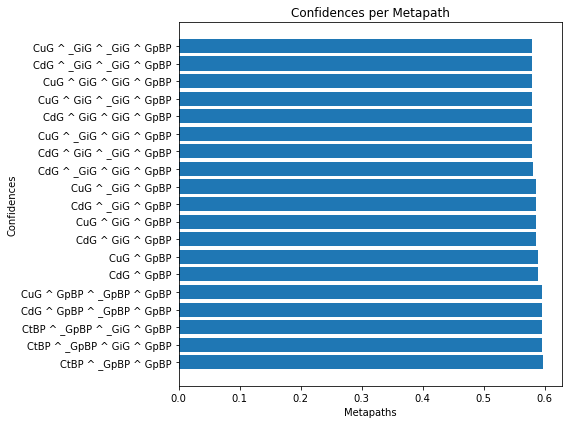

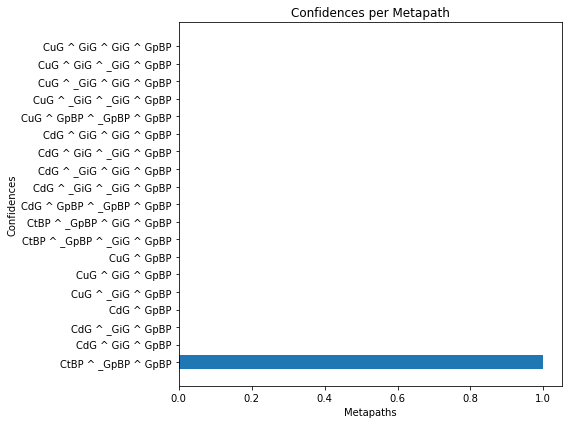

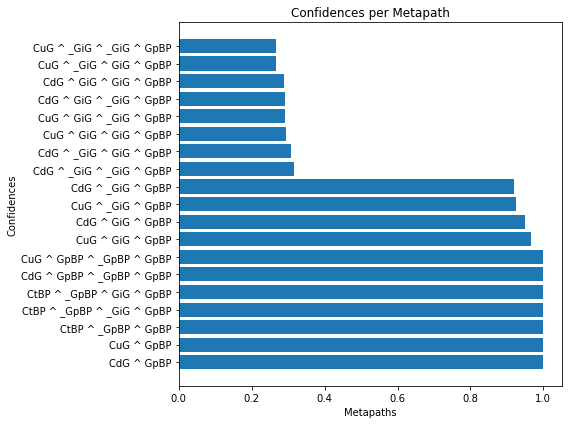

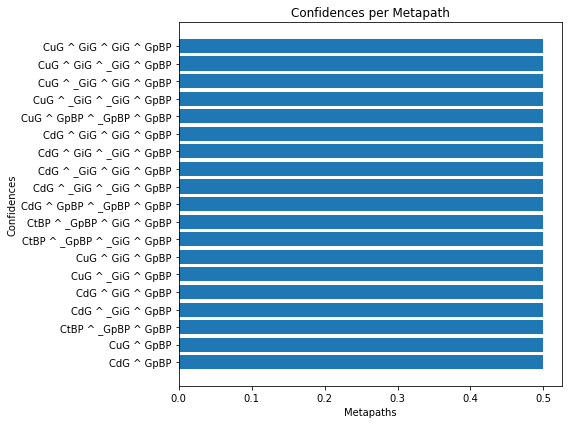

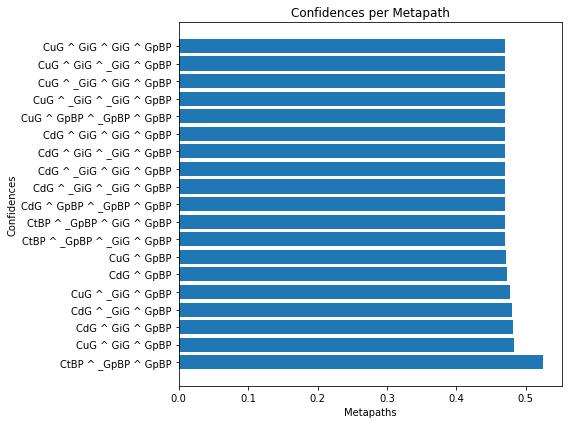

In [86]:
for subdir in tqdm(os.listdir(OG_DIR)):
    output_dir = osp.join(OG_DIR, subdir)
    if osp.isdir(output_dir):
        plot_confidences(output_dir)

# archived

XSWAP_DIR = osp.join(OUTPUT_DIR, 'MOA-net-xswap')

for subdir in tqdm(os.listdir(XSWAP_DIR)):
    output_dir = osp.join(XSWAP_DIR, subdir)
    process_polo_paths(output_dir, validation_moas)
